# Exercise 3 -- Improving the recurrent model

In this exercise we will try different ways to improve the performance of the RNN model on the PTB data set.

## Gradient clipping

As a first step, we consider the effect of gradient clipping. Gradient clipping reduces the maximum magnitude of the gradient during parameter update to a selectable value $M$. In other words during gradient descent, new parameters $\theta_k$ are determined by applying
$$
\theta_k = \theta_{k-1} - \gamma \nabla J(\theta_{k-1})
$$
where $\nabla J(\theta_{k-1})$ is the gradient and $\gamma$ the learning rate. Gradient clipping then corresponds to introduction of a function
$$
clip_M(\theta) = 
\begin{cases}
\theta & \mathrm{if} ||\theta|| \leq M \\
M \frac{\theta}{||\theta||} \qquad & \mathrm{if} ||\theta|| \leq M
\end{cases}
$$
which is applied during parameter update as follows:
$$
\theta_k = \theta_{k-1} - \gamma clip_M(\theta)(\nabla J(\theta_{k-1})).
$$
We set our model and training loops up as in exercise 2, but use the gradient clipping routine `clip_grad_norm_()` provided by pytorch in the `train()` function and also increase the learning rate as that should be safely possible with gradient clipping. 

In [1]:
import torch
from mymodel import MyNetwork
torch.manual_seed(3932324365)
device = torch.device("cuda")
model = MyNetwork().to(device)

In [2]:
from corpus import Corpus
corpus = Corpus('ptb_data')

batch_size = 100
l_seq = 20

from fcns import batchify, get_batch
train_data = batchify(corpus.train, batch_size).to(device)
val_data = batchify(corpus.valid, batch_size).to(device)
test_data = batchify(corpus.test, batch_size).to(device)

In [3]:
import torch.optim as optim
lr = 10
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = lr, weight_decay = 0, momentum = 0.0)

In [4]:
import time
import math

def train():
    model.train()
    
    for batch, i in enumerate(range(0, train_data.size(0) - 1, l_seq)):
        data, targets = get_batch(train_data, i, l_seq)
        
        optimizer.zero_grad()
        
        output, hidden = model(data)
        loss = loss_fn(output, targets)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

In [5]:
def evaluate(data_source):
    # Turn on evaluation mode which disables dropout.
    model.eval()
    total_loss = 0.
    ntokens = len(corpus.dictionary)
    
    hidden = model.init_hidden(batch_size)
    
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, l_seq):
            data, targets = get_batch(data_source, i, l_seq)
            output, hidden = model(data, hidden)
            total_loss += len(data) * loss_fn(output, targets).item()
    return total_loss / (len(data_source) - 1)

In [34]:
def train_nepochs(nepochs, best_val_loss, fname):
    
    train_loss = []
    val_loss = []
    
    for epoch in range(1, nepochs+1):
        
        epoch_start_time = time.time()
        train()
        train_loss.append(evaluate(train_data))
        val_loss.append(evaluate(val_data))
        
        time_epoch = time.time() - epoch_start_time
        model.time += time_epoch
        
        print('|          {:3d} |   {:9.1f}s |   {:5.2f} |   {:5.2f} |    {:8.2f} |    {:8.2f} |'\
              .format(model.epoch, time_epoch, model.train_loss[-1], model.val_loss[-1], 
                  math.exp(model.train_loss[-1]), math.exp(model.val_loss[-1])))
        print('-' * 78)
        
        # Save the model if the validation loss is the best we've seen so far.
        if len(model.val_loss) == 1 or model.val_loss[-1] < min(model.val_loss[:-1]):
            with open(fname_best, 'wb') as f:
                torch.save(model, f)
        
        with open(fname, 'wb') as f:
            torch.save(model, f)

With everything in place, we can proceed with the training of our model:

In [33]:
# Loop over epochs.
best_val_loss = None
nepochs = 50
log_interval = 1000
clip = .1
fname = 'exercise3_gc.torch'
fname_best = 'exercise3_gc_best.torch'

from fcns import print_log_head, load_model
from os.path import exists

if not exists(fname):
    print_log_head()
    train_nepochs(nepochs, fname, fname_best)
else:
    model = load_model(fname)

---------------------------------------------------------------------------
|              |          |       loss        |        perplexity         |
| end of epoch |   time   |-------------------|---------------------------|
|              |          |  train  |  valid  |    train    |    valid    |
---------------------------------------------------------------------------
---------------------------------------------------------------------------
|            0 |    0.00s |    4.43 |    5.01 |       84.06 |      149.39 |
---------------------------------------------------------------------------


We plot now the training and validation loss of the model in the figure below. Compared to the loss obtained in exercise 2, we find that the loss is a lot smoother as a function of epoch due to the effect of the gradient clipping. This indicates also, that the spikeyness observed in connection with exercise 2 is probably a mild form of the *exploding gradient* problem in RNNs. Furthermore gradient clipping allowed us to increase the learning rate and obatin a better validation loss than we got without gradient clipping.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()

ax.plot(np.arange(1, len(train_loss)+1), train_loss, label='train loss')
ax.plot(np.arange(1, len(val_loss)+1), val_loss, label='validation loss')
ax.legend()

Overfitting to the training data from about epoch 26 on. Annealing of learning rate could be advisable.

## Improving the flow of information

In order to improve the flow of information, we pass the hidden state on to the next training iteration. This is simply achieved by adding the hidden state to the inputs of the `model()` call. However we also need to prevent the model from backpropagating through the training iterations. We achieve this by wrapping the hidden state tensor into a new tensor, which is detached from its "history" in each iteration of the training loop. The following code snippets show the approach.

In [9]:
from fcns import repackage_hidden
from IPython.display import Code
Code(data=''.join([line for line in open('fcns.py')][34:42]), language='python')

def repackage_hidden(h):
    """ Credit for this function:
        https://github.com/pytorch/examples/blob/main/word_language_model/main.py
    """
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

In [10]:
Code(data=''.join([line for line in open('mymodel.py')][31:45]), language='python')

def forward(self, input, hidden=None):
        # Apply word embedding to input
        embedded = self.embedding(input)

        # Forward pass through the RNN layer
        if hidden is not None:
            output, hidden = self.rnn(embedded, hidden)
        else:
            output, hidden = self.rnn(embedded)

        # Apply the output layer and return the output
        output = self.output_layer(output).view(-1, self.vocab_size)

In [11]:
import time
import math

def train():
    model.train()
    hidden = model.init_hidden(batch_size)
    
    for batch, i in enumerate(range(0, train_data.size(0) - 1, l_seq)):
        data, targets = get_batch(train_data, i, l_seq)
        
        optimizer.zero_grad()
        hidden = repackage_hidden(hidden)
        output, hidden = model(data, hidden)
        loss = loss_fn(output, targets)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

Similarly we modify the `evaluate()`function to also pass the hidden state to the model:

In [12]:
def evaluate(data_source):
    # Turn on evaluation mode which disables dropout.
    model.eval()
    total_loss = 0.
    ntokens = len(corpus.dictionary)
    
    hidden = model.init_hidden(batch_size)
    
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, l_seq):
            data, targets = get_batch(data_source, i, l_seq)
            output, hidden = model(data, hidden)
            hidden = repackage_hidden(hidden)
            total_loss += len(data) * loss_fn(output, targets).item()
    return total_loss / (len(data_source) - 1)

With all code modifications in place, we can now train our model with improved information flow.

In [35]:
# Loop over epochs.
best_val_loss = None
nepochs = 50
lr = 5
clip = .1
fname = 'exercise3_iif.torch'
fname_best = 'exercise3_iif_best.torch'

if not exists(fname):
    model = MyNetwork().to(device)
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr = lr, weight_decay = 0, momentum = 0.0)
    print_log_head()
    train_nepochs(nepochs, fname, fname_best)
else:
    model = load_model(fname)

---------------------------------------------------------------------------
|              |          |       loss        |        perplexity         |
| end of epoch |   time   |-------------------|---------------------------|
|              |          |  train  |  valid  |    train    |    valid    |
---------------------------------------------------------------------------
---------------------------------------------------------------------------


NameError: name 'fname_best' is not defined

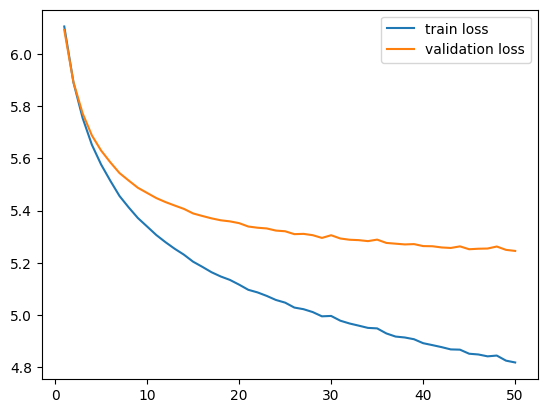

In [14]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()

ax.plot(np.arange(1, len(model.train_loss)+1), train_loss, label='train loss')
ax.plot(np.arange(1, len(model.val_loss)+1), val_loss, label='validation loss')
ax.legend()

## Gated units

We now replace the Elman RNN by the LSTM. This is easily done 

In [15]:
model = MyNetwork(rnn_type='LSTM').to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = lr, weight_decay = 0, momentum = 0.0)

In [16]:
# Loop over epochs.
best_val_loss = None
nepochs = 50
log_interval = 1000
clip = .1
fname = 'exercise3_lstm.torch'
fname_best = 'exercise3_lstm_best.torch'

if not exists(fname):
    print_log_head()
    train_nepochs(nepochs, fname, fname_best)
else:
    model = load_model(fname)

---------------------------------------------------------------------------
|              |          |       loss        |        perplexity         |
| end of epoch |   time   |-------------------|---------------------------|
|              |          |  train  |  valid  |    train    |    valid    |
---------------------------------------------------------------------------
---------------------------------------------------------------------------
|            1 |   30.51s |    6.18 |    6.17 |      482.93 |      477.86 |
---------------------------------------------------------------------------
|            2 |   30.67s |    5.95 |    5.95 |      383.73 |      383.15 |
---------------------------------------------------------------------------
|            3 |   31.06s |    5.80 |    5.81 |      329.02 |      332.11 |
---------------------------------------------------------------------------
|            4 |   31.42s |    5.68 |    5.70 |      292.76 |      299.81 |
------------

AttributeError: 'MyNetwork' object has no attribute 'train_loss'

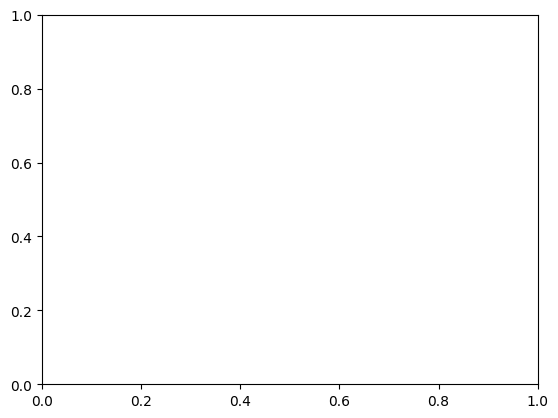

In [36]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()

ax.plot(np.arange(1, len(model.train_loss)+1), train_loss, label='train loss')
ax.plot(np.arange(1, len(model.val_loss)+1), val_loss, label='validation loss')
ax.legend()

In [18]:
model = torch.load('exercise3_lstm.torch')
test_loss = evaluate(test_data)
print('The perpelexity in the test set is {:8.2f}'.format(math.exp(test_loss)))

The perpelexity in the test set is   155.05


## Improving the model further

### Increasing the number of layers

In [19]:
# Loop over epochs.
best_val_loss = None
nepochs = 50
log_interval = 1000
clip = .1
fname = 'exercise3_lnl.torch'
fname_best = 'exercise3_lnl_best.torch'

if not exists(fname):
    model = MyNetwork(rnn_type='LSTM', nlayers=2).to(device)
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr = lr, weight_decay = 0, momentum = 0.0)
    print_log_head()
    train_nepochs(nepochs, fname, fname_best)
else:
    model = load_model(fname)

---------------------------------------------------------------------------
|              |          |       loss        |        perplexity         |
| end of epoch |   time   |-------------------|---------------------------|
|              |          |  train  |  valid  |    train    |    valid    |
---------------------------------------------------------------------------
---------------------------------------------------------------------------
|            1 |   35.19s |    6.50 |    6.49 |      664.68 |      659.69 |
---------------------------------------------------------------------------
|            2 |   36.14s |    6.24 |    6.24 |      513.63 |      512.40 |
---------------------------------------------------------------------------
|            3 |   37.14s |    6.01 |    6.01 |      406.12 |      405.51 |
---------------------------------------------------------------------------
|            4 |   35.70s |    5.85 |    5.86 |      346.08 |      350.06 |
------------

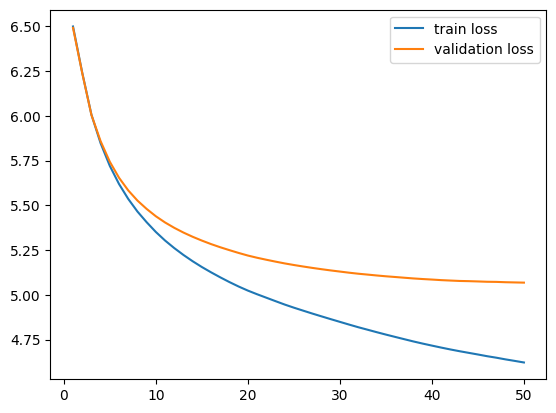

In [20]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()

ax.plot(np.arange(1, len(model.train_loss)+1), train_loss, label='train loss')
ax.plot(np.arange(1, len(model.val_loss)+1), val_loss, label='validation loss')
ax.legend()

In [21]:
model = torch.load(fname_best)
test_loss = evaluate(test_data)
print('The perpelexity in the test set is {:8.2f}'.format(math.exp(test_loss)))

The perpelexity in the test set is   177.91


### Use a learning rate scheduler

In [22]:
def train_nepochs(nepochs, best_val_loss, fname):
    
    train_loss = []
    val_loss = []
    
    for epoch in range(1, nepochs+1):
        
        epoch_start_time = time.time()
        train()
        train_loss.append(evaluate(train_data))
        val_loss.append(evaluate(val_data))

        scheduler.step(val_loss[-1])
        
        time_epoch = time.time() - epoch_start_time
        model.time += time_epoch
        
        print('|          {:3d} |   {:9.1f}s |   {:5.2f} |   {:5.2f} |    {:8.2f} |    {:8.2f} |'\
              .format(model.epoch, time_epoch, model.train_loss[-1], model.val_loss[-1], 
                  math.exp(model.train_loss[-1]), math.exp(model.val_loss[-1])))
        print('-' * 78)
        
        # Save the model if the validation loss is the best we've seen so far.
        if len(model.val_loss) == 1 or model.val_loss[-1] < min(model.val_loss[:-1]):
            with open(fname_best, 'wb') as f:
                torch.save(model, f)
        
        with open(fname, 'wb') as f:
            torch.save(model, f)

In [23]:
# Loop over epochs.
best_val_loss = None
nepochs = 50
log_interval = 1000
lr = 10
clip = .1
fname = 'exercise3_lrsched.torch'
fname_best = 'exercise3_lrsched_best.torch'

if not exists(fname):
    model = MyNetwork(rnn_type='LSTM', nlayers=2).to(device)
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr = lr, weight_decay = 0, momentum = 0.0)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
    print_log_head()
    train_nepochs(nepochs, fname, fname_best)
else:
    model = load_model(fname)

---------------------------------------------------------------------------
|              |          |       loss        |        perplexity         |
| end of epoch |   time   |-------------------|---------------------------|
|              |          |  train  |  valid  |    train    |    valid    |
---------------------------------------------------------------------------
---------------------------------------------------------------------------
|            1 |   35.31s |    6.22 |    6.20 |      501.61 |      494.23 |
---------------------------------------------------------------------------
|            2 |   35.50s |    5.81 |    5.82 |      334.07 |      337.13 |
---------------------------------------------------------------------------
|            3 |   35.51s |    5.59 |    5.62 |      267.91 |      276.97 |
---------------------------------------------------------------------------
|            4 |   35.67s |    5.44 |    5.50 |      230.46 |      244.77 |
------------

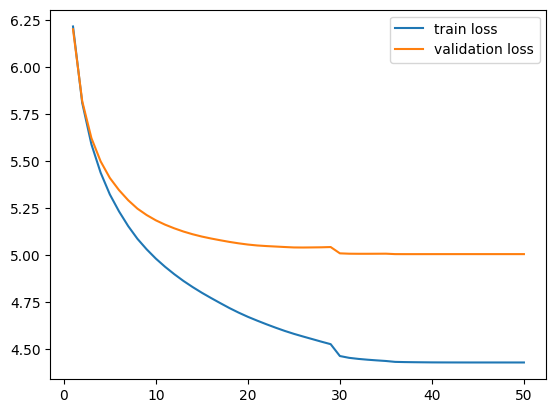

In [24]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()

ax.plot(np.arange(1, len(model.train_loss)+1), train_loss, label='train loss')
ax.plot(np.arange(1, len(model.val_loss)+1), val_loss, label='validation loss')
ax.legend()

With the 2 layers in the LSTM network and using a learning rate shceduler we reach an improved perplexity rating of 142.38 on the test set:

In [25]:
model = torch.load(fname_best)
test_loss = evaluate(test_data)
print('The perpelexity in the test set is {:8.2f}'.format(math.exp(test_loss)))

The perpelexity in the test set is   143.66
